Genevieve Chafouleas (20144781) \\
Dylan Troop (20150906)  \\
Maksym Perepichka (p1192794)  \\

Github: [https://github.com/gchafouleas/IFT6135_Assignment_1](https://github.com/gchafouleas/IFT6135_Assignment_1)

In [0]:
# Google Drive Mounting (Should be run before if you want access to local files)
from google.colab import drive

drive.mount("/content/drive")

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
# Packages

import numpy as np

import torch
import torchvision

import matplotlib
import matplotlib.pyplot as plt
from torch.utils.data.sampler import SequentialSampler

import os, pickle

In [0]:
# Set up training data

DEFAULT_MNIST_PATH_TRAIN = "/content/drive/My Drive/IFT 6135"
DEFAULT_MNIST_PATH_TEST = "/content/drive/My Drive/IFT 6135"
DEFAULT_BATCH_SIZE = 100

from torchvision import transforms

def download_mnist(path_train=DEFAULT_MNIST_PATH_TRAIN,
                   path_test=DEFAULT_MNIST_PATH_TEST):
    """Downloads MNIST Training and Testing datasets."""
    
    train = torchvision.datasets.MNIST(
        root=path_train,
        train=True,
        download=True,
        transform=transforms.ToTensor()
    )

    test = torchvision.datasets.MNIST(
        root=path_test,
        train=False,
        download=True,
        transform=transforms.ToTensor()
    )
    
    return train, test

def load_mnist(train_ds, test_ds, batch_size):
    #implement cross validation using 80% for training and 20% for validastion set: 
    validation_split = 0.2
    dataset_size = len(train_ds)
    indices = list(range(dataset_size))
    validation_split = int(np.floor(validation_split * dataset_size))
    train_indices, valid_indices = indices[validation_split:], indices[:validation_split]
    train_sampler = SequentialSampler(train_indices)
    validation_sampler = SequentialSampler(valid_indices)
    
    train = torch.utils.data.DataLoader(
        dataset=train_ds,
        batch_size=batch_size,
        sampler=train_sampler
    )
    
    valid = torch.utils.data.DataLoader(
        dataset=train_ds,
        batch_size=batch_size,
        sampler=validation_sampler
    )
    
    test = torch.utils.data.DataLoader(
        dataset=test_ds,
        batch_size=batch_size,
        shuffle=False
    )
    
    return train, valid, test

train_ds, test_ds = download_mnist(path_train=DEFAULT_MNIST_PATH_TRAIN,
                                   path_test=DEFAULT_MNIST_PATH_TEST)


train, valid, test = load_mnist(train_ds, test_ds, DEFAULT_BATCH_SIZE)

  


# Problem 1

---



In [0]:
DEFAULT_MODEL_PATH = "/content/drive/My Drive/IFT 6135/Question_1/Model"

class NN:
    
    def __init__(self, weight_init = 'glorot', hidden_dims = (500, 500),
                 n_hidden = 2, seed = 0):
        dims = [784] + list(hidden_dims) + [10]
        
        self.weight_init = weight_init
      
        if weight_init == 'zero':
            self.initialize_weights_zero(n_hidden, dims)
        
        if weight_init == 'normal':
            self.initialize_weights_normal(n_hidden, dims, seed)
        
        if weight_init == 'glorot':
            self.initialize_weights_glorot(n_hidden, dims, seed)

        self.L = n_hidden
    
    def initialize_weights_zero(self, n_hidden, dims):    
        self.W = []
        self.b = []
        for i in range(n_hidden+1):        
            self.W.append(np.zeros([dims[i+1], dims[i]]))
            self.b.append(np.zeros([dims[i+1], 1]))
      
    def initialize_weights_normal(self, n_hidden, dims, seed = 0):
        np.random.seed(seed)
        self.W = []
        self.b = []
        for i in range(n_hidden+1):
            self.W.append(np.random.randn(dims[i+1], dims[i]))
            self.b.append(np.zeros([dims[i+1], 1]))     
          
    def initialize_weights_glorot(self, n_hidden, dims, seed = 0):
        np.random.seed(seed)
        self.W = []
        self.b = []
        for i in range(n_hidden+1):
            dl = np.sqrt(6/(dims[i]+dims[i+1]))
            self.W.append(np.random.uniform(-dl, dl,(dims[i+1], dims[i])))
            self.b.append(np.zeros([dims[i+1], 1]))
    
    def activation(self, x):
        if self.weight_init == 'normal':
            # use logistic
            return 1/(1+np.exp(-x))
        else:
            # use reLu
            return np.maximum(0, x)

    def activ_grad(self, x):
        if self.weight_init == 'normal':
            # use logistic
            return np.exp(-x)/(1+np.exp(-x))**2
        else:
            # use reLu
            return(x > 0).astype(np.float)
    
    def loss(self, yHat, y):
        i = np.nonzero(y)
        return -np.sum(np.log(yHat)[i])/y.shape[0]

    def loss_grad(self, yHat, y):
        return -y/yHat
    
    def softmax(self, x):
        exps = np.exp(x - np.max(x))
        return exps / np.sum(exps, axis = 1, keepdims = True)
    
    def softmax_grad(self, x):
        n = x.shape[0]
        p = x.shape[1]
        y = self.softmax(x)
        J = np.ndarray((n, p, p))
        for i in range(n):
            for j in range(p):
                for k in range(p):
                    if j == k:
                        J[i,j,k] = y[i,j] * (1 - y[i,k])
                    else:
                        J[i,j,k] = -y[i,j] * y[i,k]
        return J
    
    def update(self, dJdW, dJdb):
        self.W -= np.multiply(self.learning_rate, dJdW)
        self.b -= np.multiply(self.learning_rate, dJdb)
    
    def forward(self, x, y, W, b, L):
        a = []
        h = []

        x = x.T
  
        for i in range(L+1):
            if i == 0:
                ac = b[i] + np.matmul(W[i], x)
            else:
                ac = b[i] + np.matmul(W[i], h[i-1].T)
      
            a.append(ac.T)
    
            if (i != L):
                h.append(self.activation(ac.T))
        
        yHat = self.softmax(a[L])
        l = self.loss(yHat, y)
  
        return l, yHat, a, h

    def backward(self, x, y, yHat, a, h, W, b, L):
        n = x.shape[0]

        dJdW = [0] * (L+1)
        dJdb = [0] * (L+1)

        g = self.loss_grad(yHat, y).reshape(y.shape[0], 1, y.shape[1])

        for i in reversed(range(L+1)):
            if i == L:
                sg = self.softmax_grad(a[L])
                g = np.matmul(g, sg)
            else:
                ag = self.activ_grad(a[i]).reshape(a[i].shape[0], 1, a[i].shape[1])
                g = np.multiply(g, ag)

            if i != 0:
                hi = h[i-1]
            else:
                hi = x

            hi = hi.reshape(hi.shape[0], 1, hi.shape[1])

            dJdW[i] = np.sum(np.matmul(g.reshape(g.shape[0], g.shape[2], 1), hi), 
                             axis = 0)/n

            dJdb[i] = np.sum(g, axis = 0).T/n

            g = np.matmul(g, W[i])

        g = np.sum(g, axis = 0)/n

        return g, dJdW, dJdb
            
    def train(self, train_loader, num_epoch, learning_rate):
        self.learning_rate = learning_rate
        
        self.loss_per_epoch = []
        
        for i in range(num_epoch):
            print("Starting epoch ", i)
            loss_per_batch = []
            for i, data in enumerate(train_loader):            
                inputs, labels = data
                inputs = inputs.numpy().reshape(DEFAULT_BATCH_SIZE,784)
                labels = labels.numpy()
            
                y = np.zeros([DEFAULT_BATCH_SIZE, 10])
                for i in range(DEFAULT_BATCH_SIZE):
                    y[i, labels[i]] = 1

                l, yHat, a, h = self.forward(inputs, y, self.W, self.b, self.L)
                g, dJdW, dJdb = self.backward(inputs, y, yHat, a, h, self.W, self.b, self.L)
                self.update(dJdW, dJdb)
                
                loss_per_batch.append(l)
                
            self.loss_per_epoch.append(np.mean(loss_per_batch))
    
    def test_accuracy(self, test_loader):
        total = 0
        correct = 0
        for i, data in enumerate(test_loader):
            inputs, labels = data
            inputs = inputs.numpy().reshape(DEFAULT_BATCH_SIZE,784)
            labels = labels.numpy()
            l, yHat, a, h = self.forward(inputs, labels, self.W, self.b, self.L)
            preds = np.argmax(yHat, axis = 1)
    
            correct += sum(preds == labels)
            total += len(labels)
        
        return(correct/total)
        

In [0]:
# Save / load model functions

def save_nn(obj, filename):
    save_file = open(os.path.join(DEFAULT_MODEL_PATH, filename), "wb")
    pickle.dump(obj, save_file)
    save_file.close()
    
def load_nn(filename):
    load_file = open(os.path.join(DEFAULT_MODEL_PATH, filename), "rb")
    obj = pickle.load(load_file)
    load_file.close()
    return obj

In [0]:
# Train and save models

# zero initialization
nn_zero = NN(weight_init = "zero")
nn_zero.train(train, 10, 0.01)
save_nn(nn_zero, "nn_zero.pickle")

# normal initialization
nn_normal = NN(weight_init = "normal")
nn_normal.train(train, 10, 0.01)
save_nn(nn_normal, "nn_normal.pickle")

# glorot initialization
nn_glorot = NN(weight_init = "glorot")
nn_glorot.train(train, 10, 0.01)
save_nn(nn_glorot, "nn_glorot.pickle")

We have trained three models with different parameter initializations: all weights set to zero, all weights sampled from a standard normal distribution, and all weights sampled from a uniform distribution (glorot). In each case the initial biases are set to zero. We have trained each model for 10 epochs with a learning rate of 0.01 and a mini batch size of 100. The model has 500 hidden units in each of its 2 hidden layers, amounting to a total of 648010 parameters including biases. The activations used for the zero and glorot initializations is reLu. With standard normal initialization, reLu activation causes overflow when computing the gradient. To overcome this, we have opted to use logistic (sigmoid) activation with normal initialization.

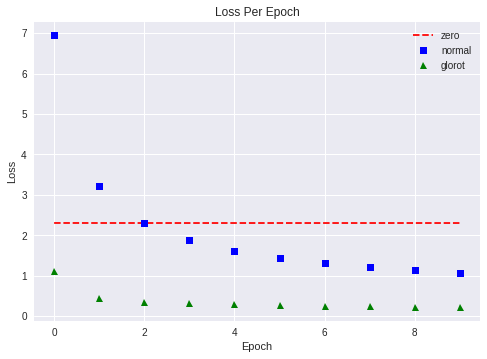

In [0]:
# Plot loss

nn_zero = load_nn("nn_zero.pickle")
nn_normal = load_nn("nn_normal.pickle")
nn_glorot = load_nn("nn_glorot.pickle")

plt.plot(nn_zero.loss_per_epoch, 'r--', nn_normal.loss_per_epoch, 'bs', nn_glorot.loss_per_epoch, 'g^')
plt.ylabel("Loss")
plt.xlabel("Epoch")
plt.title("Loss Per Epoch")
plt.legend(labels = ["zero", "normal", "glorot"])
plt.show()

The graph above shows the average loss after each epoch during training of the three models. The loss is constant for zero initialization, since the gradient will always be zero and thus parameters are never updated. The loss decreases over time with the two other initialization methods, which is expected as the gradient descent finds better parameter estimates. The glorot initialization maintains the best performance. Below we see the accuracies for each model at the end of training:

In [0]:
print("Zero initialization:")
print("training accuracy: ", nn_zero.test_accuracy(train))
print("validation accuracy: ", nn_zero.test_accuracy(valid))
print("test accuracy: ", nn_zero.test_accuracy(test))
print("\n")
print("Normal initialization:")
print("training accuracy: ", nn_normal.test_accuracy(train))
print("validation accuracy: ", nn_normal.test_accuracy(valid))
print("test accuracy: ", nn_normal.test_accuracy(test))
print("\n")
print("Glorot initialization:")
print("training accuracy: ", nn_glorot.test_accuracy(train))
print("validation accuracy: ", nn_glorot.test_accuracy(valid))
print("test accuracy: ", nn_glorot.test_accuracy(test))

Zero initialization:
training accuracy:  0.11395833333333333
validation accuracy:  0.11258333333333333
test accuracy:  0.1135


Normal initialization:
training accuracy:  0.7900833333333334
validation accuracy:  0.79725
test accuracy:  0.7843


Glorot initialization:
training accuracy:  0.9412708333333333
validation accuracy:  0.945
test accuracy:  0.9413


### Hyperparameter Search

In [0]:
def find_parms(P, m1):
    # number of weights in second layer given m1 weights in first layer
    # and P total parameters
    return np.floor((P-10-785*m1)/(m1+11))

print(find_parms(1e6, 750))
print(find_parms(5e5, 600))
print(48*(600+11)+10+785*600)

540.0
47.0
500338


We now attempt to improve the accuracy on the validation set with glorot initialization by adjusting model hyperparameters. We adjust the number of hidden units in the first layer to 750. To get our model to have roughly 1 million parameters, the second layer should have 540 hidden units. The total number of parameters is now 999260. We also increase the learning rate to 0.05, and train the new model.

In [0]:
nn_glorot_final = NN(weight_init = "glorot", hidden_dims = (750, 540))
nn_glorot_final.train(train, 10, 0.05)
save_nn(nn_glorot_final, "nn_glorot_final.pickle")

In [0]:
nn_glorot_final = load_nn("nn_glorot_final.pickle")
print("training accuracy: ", nn_glorot_final.test_accuracy(train))
print("validation accuracy: ", nn_glorot_final.test_accuracy(valid))
print("test accuracy: ", nn_glorot_final.test_accuracy(test))

training accuracy:  0.9828125
validation accuracy:  0.982
test accuracy:  0.9704


After training the new model, we achieve the desired accuracy (>97%) on the validation set.

We now decrease the total number of parameters to around 500000. We can acheive this with 600 hidden units in the first layer followed by 48 hidden units in the second layer. This brings the total number of parameters to 500338. We shall also decrease the learning rate to 0.03.

In [0]:
# glorot initialization
nn_glorot_alt = NN(weight_init = "glorot", hidden_dims = (600, 48))
nn_glorot_alt.train(train, 10, 0.03)
save_nn(nn_glorot_alt, "nn_glorot_alt.pickle")

In [0]:
nn_glorot_alt = load_nn("nn_glorot_alt.pickle")
print("training accuracy: ", nn_glorot_alt.test_accuracy(train))
print("validation accuracy: ", nn_glorot_alt.test_accuracy(valid))
print("test accuracy: ", nn_glorot_alt.test_accuracy(test))

training accuracy:  0.9730625
validation accuracy:  0.9734166666666667
test accuracy:  0.9649


We get slightly lower accuracy in this case, which is expected due to the decreased learning rate and number of parameters. 

### Validate Gradients using Finite Difference

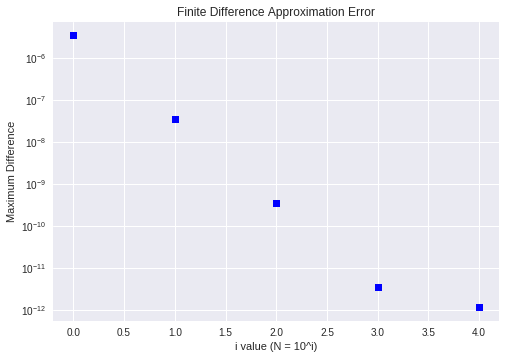

In [0]:
def finite_diff(model, N, p, x, y):
    eps = 1/N
    W = model.W
    w = W[1][0, p]
    
    W[1][0, p] = w + eps
    l1, yHat, a, h = model.forward(x, y, W, model.b, model.L)
    
    W[1][0, p] = w - eps
    l2, yHat, a, h = model.forward(x, y, W, model.b, model.L)
    
    # reset value
    W[1][0, p] = w

    fd = (l1 - l2)/(2 * eps)
    
    return fd

for i, data in enumerate(train):            
    x, labels = data
    x = x.numpy().reshape(DEFAULT_BATCH_SIZE,784)
    labels = labels.numpy()
    y = np.zeros([DEFAULT_BATCH_SIZE, 10])
    for i in range(DEFAULT_BATCH_SIZE):
        y[i, labels[i]] = 1
    break

x = x[0, ].reshape(1, 784)
y = y[0, ].reshape(1, 10)

nn = load_nn("nn_glorot_final.pickle")
Ns = []
max_err = []

for i in range(5):
    N = 10**i
    Ns.append(N)
    err = []
    for p in range(10):
        fdw = finite_diff(nn, N, p, x, y)
        l, yHat, a, h = nn.forward(x, y, nn.W, nn.b, nn.L)
        g, dJdW, dJdb = nn.backward(x, y, yHat, a, h, nn.W, nn.b, nn.L)
        gw = dJdW[1][0, p]
        err.append(np.abs(fdw - gw))
    max_err.append(np.max(err))

plt.plot(max_err, 'bs')
plt.yscale('log')
plt.xlabel("i value (N = 10^i)")
plt.ylabel("Maximum Difference")
plt.title("Finite Difference Approximation Error")
plt.show()

The graph above shows the error (absolute value difference) between the gradient and its finite difference $\epsilon$-approximation, where $\epsilon = 1/N$. Here we are considering the gradient of the loss function with respect to the second layer weights, and plotting the maximum error among the first 10 weights. The gradient and its $\epsilon$-approximation is calculated at the weight values obtained in our final trained model with glorot initialization.

# Problem 2

---



## Initial model.

We started with a basic model with only two convolutions. Each convolution was followed by a max pooling of squared kernel of size 5. Finally, we have two fully connected layers at the end. We used the Relu activation function. 

In [0]:
import torch
import torchvision
from torch.autograd import Variable
import torch.nn.functional as F
import torch.nn as nn
import numpy as np

import logging
import importlib
import copy
from collections import OrderedDict
from google.colab import files
import matplotlib as mpl
#import matplotlib.pylot as plt
print(dir(mpl))

seed = 42
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
torch.backends.cudnn.deterministic=True

DEFAULT_NUM_EPOCHS = 10

DEFAULT_MODEL_PATH = '/content/drive/My Drive/IFT 6135/question2_model'

DEFAULT_VALID_CONV_PARAMS = [
    'input_size', 'output_size', 'padding_size', 'stride_size', 'dilation_size'
]

# Hyper-parameters
DEFAULT_HYPER_PARAMS = OrderedDict(
    
    conv1 = dict(
        input_size = 1,
        output_size = 64,
        kernel_size = (3,3),
        padding_size = 2,
        stride_size = 2,
        dilation_size = 1,
    ),
     
    relu1 = dict(),
    
    pool1 = dict(
        kernel_size = (5,5),
        stride_size= 2,
    ),
    
    conv2 = dict(
        input_size = 64,
        output_size = 512,
        kernel_size = (3,3),
        padding_size = 2,
        stride_size = 2,
        dilation_size = 1,
    ),
    
    relu2 = dict(),
    
    pool2 = dict(
        kernel_size = (5,5),
        stride_size = 2,
    ),
    
    fc1 = dict(
        input_size=512,
        output_size=100,
    ),
    
    relu3 = dict(),
    
    fc2 = dict(
        input_size=100,
        output_size=10
    ),
    
 
)

# Sets up logging
importlib.reload(logging)
logging.basicConfig(
    format='%(asctime)s %(message)s', datefmt='%m/%d/%Y %I:%M:%S %p'
)


class CNN(torch.nn.Module):
  
    def __init__(self, optimizer=torch.optim.SGD,
                 learning_rate =1e-2, 
                 criterion=torch.nn.CrossEntropyLoss,
                 use_cuda=True, model_path=DEFAULT_MODEL_PATH, *args, **kwargs):
        """
        Initializes a generic CNN. Layers and parameters can be passed via 
        keyword arguments.
        
        """
      
        # Call to super-constructor
        super(CNN, self).__init__()
        print(learning_rate)
        self.path = model_path
        # Sets up separate ordered dictionaries for conv and fc parts
        self.conv_params = OrderedDict()
        self.fc_params = OrderedDict()
               
        # Parses dictionary of parameters
        previous = None
        for key, value in kwargs.items():
            
            if 'conv' in key:
                try:
                    self.conv_params[key] = nn.Conv2d(
                        in_channels = value.get('input_size', None),
                        out_channels = value.get('output_size', None),
                        stride = value.get('stride_size', 1),
                        padding = value.get('padding_size', 0),
                        dilation = value.get('dilation_size', 1),
                        kernel_size = value.get('kernel_size', (3,3)),
                    )
                    previous = 'conv'
                except Exception as e:
                    logging.warning(
                        'Unable to create Conv layer {}. Exception: {} '.format(
                        key, e)
                    )

            elif 'relu' in key:
                # Need to check which type of layer was before this one
                if previous == 'conv':
                    self.conv_params[key] = nn.ReLU()
                elif previous == 'fc':
                    self.fc_params[key] = nn.ReLU()
                else:
                    logging.warning(
                    'Cannot start with an activation layer. Ignoring {}'.format(
                        key)
                    )
            elif 'pool' in key:
                try:
                    self.conv_params[key] = nn.MaxPool2d(
                        stride = value.get('stride_size', None),
                        kernel_size = value.get('kernel_size', None),
                    )
                except Exception as e:
                    logging.warning('Unable to create MaxPool layer {}'.format(
                        key)
                    )
                    previous = 'conv'
            elif 'fc' in key:  
                try:
                    self.fc_params[key] = nn.Linear(
                        value.get('input_size', None),
                        value.get('output_size', None),
                    )
                    previous = 'fc'
                except Exception as e:
                    logging.warning(
                        'Unable to create linear layer {}. Exception: {} '.format(
                        key, e)
                    )
            elif key in self.conv_params or key in self.fc_params:
                logging.warning(
                    'Parameter {} is already set. Ignored redefinition.'.format(
                        key)
                )
            else:
                logging.warning(
                    'Ignored unrecognized parameter {}.'.format(
                        key)
                )
        
        # Sets up layers based on parameters
        self.conv = nn.Sequential(self.conv_params)
        self.fc = nn.Sequential(self.fc_params)
        
        # Sets up loss and optimizers
        self.optimizer = optimizer(
            self.parameters(), lr=learning_rate, momentum=0.0
        )
        self.criterion = criterion()
        
        # Sets up other parameters
        if torch.cuda.is_available() and use_cuda:
            self.use_cuda = True
        
    def forward(self, x):      
        """Forward pass of the neural network. """
        return self.fc(self.conv(x).squeeze())
    
    def save(self, path=None):
        """Saves the model to the desired path."""
        if path is None:
            path = self.path
            
        torch.save(self.state_dict(), path)
        
    def load(self, path=None):
        """Loads the model from desired path."""
        if path is None:
            path = self.path
            
        self.load_state_dict(torch.load(path))
        
    def test(self, test_loader):
      total = 0
      correct = 0
      for i,data in enumerate(test_loader):
        inputs,targets = data
        if self.use_cuda:
           inputs, targets = inputs.cuda(), targets.cuda()
        
        outputs = self(inputs)
        _, predicted = torch.max(outputs.data, 1)
        total += targets.size(0)
        correct += predicted.eq(targets.data).cpu().sum().item()
      return 100*(correct/total)
        
    def train_model(self, train_loader, valid_loader,
                    num_epochs=DEFAULT_NUM_EPOCHS, save_mode='every',
                    smart_detection=True,  silent=False):
        """Trains the model.
        

        :param train_loader: DataLoader for the training set.
        :param test_loader: DataLoader for the testing set.
        :param save_mode: Mode of saving. Choose between:
            None: No saving.
            (string) 'every': Save at every epoch.
            (string) 'end': Save at end of training.
            (int) n: Save at every n'th epoch.
        :param smart_detection: Autodetect best epoch.
        :param num_epochs: Number of epochs to train for.
        :param silent: Whether or not to output messages at every epoch.
        
        
        """
        
        train_losses = []
        valid_losses = []
        
        train_error = []
        valid_error = []
        
        for epoch in range(num_epochs):
            print("running epoch: ", epoch)  
            losses = []
            total = 0
            correct = 0
            self.train()
            for batch, (inputs, targets) in enumerate(train_loader):
                
                if self.use_cuda:
                    inputs, targets = inputs.cuda(), targets.cuda()
                    
                self.optimizer.zero_grad()
                outputs = self(inputs)
                loss = self.criterion(outputs, targets)
                loss.backward()
                self.optimizer.step()
                losses.append(loss.data.item())
                _, predicted = torch.max(outputs.data, 1)
                total += targets.size(0)
                correct += predicted.eq(targets.data).cpu().sum().item()


                if batch%50==0 and not silent:
                    logging.info('Epoch : %d Loss : %.3f ' % (epoch, np.mean(losses)))
                
            train_error.append(100. - 100.*(correct/total))
            total = 0
            correct = 0
            self.eval()
            for batch_idx, (inputs, targets) in enumerate(valid_loader):
                if self.use_cuda:
                    inputs, targets = inputs.cuda(), targets.cuda()

                outputs = self(inputs)
                _, predicted = torch.max(outputs.data, 1)
                total += targets.size(0)
                correct += predicted.eq(targets.data).cpu().sum().item()
                
            train_losses.append(np.mean(losses))
            print('Epoch : %d Test Acc : %.3f' % (epoch, 100.*correct/total))
            print('--------------------------------------------------------------')
            valid_error.append(100. - 100.*(correct/total))
            
            if save_mode == 'every' or epoch % save_mode == 0:
                self.save('{}_{}'.format(self.path, epoch))
                
        return train_error,valid_error     
    
        

['MatplotlibDeprecationWarning', 'MutableMapping', 'Parameter', 'Path', 'RcParams', 'URL_REGEX', 'Verbose', '_DATA_DOC_APPENDIX', '__bibtex__', '__builtins__', '__cached__', '__doc__', '__file__', '__loader__', '__name__', '__package__', '__path__', '__spec__', '__version__', '__version__numpy__', '__warningregistry__', '_add_data_doc', '_all_deprecated', '_cm', '_cm_listed', '_color_data', '_constrained_layout', '_contour', '_create_tmp_config_dir', '_deprecated_ignore_map', '_deprecated_map', '_deprecated_remain_as_none', '_error_details_fmt', '_get_config_or_cache_dir', '_get_data_path', '_get_xdg_cache_dir', '_get_xdg_config_dir', '_image', '_init_tests', '_layoutbox', '_log', '_logged_cached', '_mathtext_data', '_open_file_or_url', '_parse_commandline', '_path', '_png', '_preprocess_data', '_pylab_helpers', '_qhull', '_rc_params_in_file', '_replacer', '_set_logger_verbose_level', '_tri', '_verbose_msg', '_version', 'afm', 'artist', 'atexit', 'axes', 'axis', 'backend_bases', 'backe

Below we run the basic model without any adjustments to the hyperparameters in order to see the initial accuracy without any changes. 

0.01
Number of parameters:  348374
running epoch:  0
Epoch : 0 Test Acc : 39.083
--------------------------------------------------------------
running epoch:  1
Epoch : 1 Test Acc : 42.492
--------------------------------------------------------------
running epoch:  2
Epoch : 2 Test Acc : 58.975
--------------------------------------------------------------
running epoch:  3
Epoch : 3 Test Acc : 72.058
--------------------------------------------------------------
running epoch:  4
Epoch : 4 Test Acc : 82.250
--------------------------------------------------------------
running epoch:  5
Epoch : 5 Test Acc : 87.258
--------------------------------------------------------------
running epoch:  6
Epoch : 6 Test Acc : 90.058
--------------------------------------------------------------
running epoch:  7
Epoch : 7 Test Acc : 91.975
--------------------------------------------------------------
running epoch:  8
Epoch : 8 Test Acc : 93.175
-----------------------------------------------

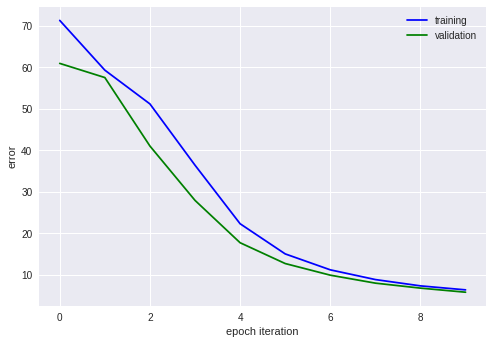

In [0]:
if __name__ == '__main__':
    
    clf = CNN(**DEFAULT_HYPER_PARAMS)
    if torch.cuda.is_available():
        logging.info('Running on GPU')
        clf = clf.cuda()
        
    print("Number of parameters: ", sum(p.numel() for p in clf.parameters() if p.requires_grad))
    
    train_error,valid_error = clf.train_model(train, valid)
    print(train_error)
    print(valid_error)
    print("This is the training error, validation error vs epochs")
    
    epoch_range = list(range(DEFAULT_NUM_EPOCHS))
    plt.figure(1)
    plt.plot(epoch_range, train_error, '-', color='b')
    plt.plot(epoch_range, valid_error, '-', color='g')
    plt.ylabel("error")
    plt.xlabel("epoch iteration")
    plt.legend(labels = ["training", "validation"])
    plt.show()

We can see that with a basic convolution neural network with only 10 epoch we can get 94.158% accuracy on the validation set. We can see that with a very small amount of parameters (348374) we can get a good accuracy of the model without even doing hyperparameter adjustment.  

##1. Increase learning rate

We then run the model with an increase learing rate of 0.05.

0.05
Number of parameters:  348374
running epoch:  0
Epoch : 0 Test Acc : 70.758
--------------------------------------------------------------
running epoch:  1
Epoch : 1 Test Acc : 92.692
--------------------------------------------------------------
running epoch:  2
Epoch : 2 Test Acc : 94.933
--------------------------------------------------------------
running epoch:  3
Epoch : 3 Test Acc : 95.700
--------------------------------------------------------------
running epoch:  4
Epoch : 4 Test Acc : 96.083
--------------------------------------------------------------
running epoch:  5
Epoch : 5 Test Acc : 96.508
--------------------------------------------------------------
running epoch:  6
Epoch : 6 Test Acc : 96.725
--------------------------------------------------------------
running epoch:  7
Epoch : 7 Test Acc : 96.958
--------------------------------------------------------------
running epoch:  8
Epoch : 8 Test Acc : 97.167
-----------------------------------------------

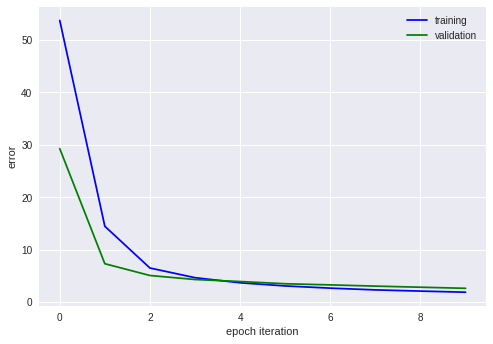

In [0]:
torch.manual_seed(0)
if __name__ == '__main__':
    
    clf = CNN(**DEFAULT_HYPER_PARAMS, learning_rate=0.05)
    if torch.cuda.is_available():
        logging.info('Running on GPU')
        clf = clf.cuda()
    
    print("Number of parameters: ", sum(p.numel() for p in clf.parameters() if p.requires_grad))
    
    train_error,valid_error = clf.train_model(train, valid)
    print(train_error)
    print(valid_error)
    print("This is the training error, validation error vs epochs")
    
    epoch_range = list(range(DEFAULT_NUM_EPOCHS))
    plt.figure(1)
    plt.plot(epoch_range, train_error, '-', color='b')
    plt.plot(epoch_range, valid_error, '-', color='g')
    plt.ylabel("error")
    plt.xlabel("epoch iteration")
    plt.legend(labels = ["training", "validation"])
    plt.show()

We can see that Increasing the learning rate to 0.05 increased the validation accuracy by quite a lot to 97.375. 

##Adding more layers
We then add more layers to our first architecture in order to create a deeper network. We added one more convolution layer and one more max pooling and removed the padding and reduced the stride for each convolution.  We also changed the pooling to use squared kernels of size 2 with stride of 2. Our new architecture as a total of 755530 parameter. 

0.05
Number of parameters:  755530
running epoch:  0
Epoch : 0 Test Acc : 84.750
--------------------------------------------------------------
running epoch:  1
Epoch : 1 Test Acc : 93.600
--------------------------------------------------------------
running epoch:  2
Epoch : 2 Test Acc : 95.342
--------------------------------------------------------------
running epoch:  3
Epoch : 3 Test Acc : 96.508
--------------------------------------------------------------
running epoch:  4
Epoch : 4 Test Acc : 97.175
--------------------------------------------------------------
running epoch:  5
Epoch : 5 Test Acc : 97.467
--------------------------------------------------------------
running epoch:  6
Epoch : 6 Test Acc : 97.850
--------------------------------------------------------------
running epoch:  7
Epoch : 7 Test Acc : 98.092
--------------------------------------------------------------
running epoch:  8
Epoch : 8 Test Acc : 98.383
-----------------------------------------------

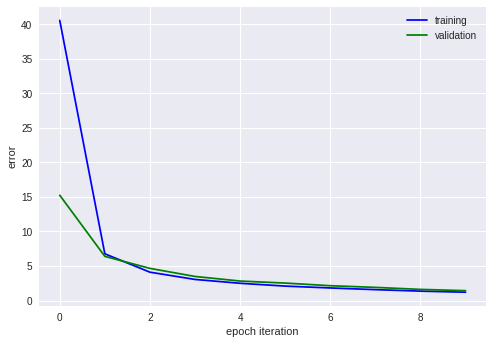

In [0]:
HYPER_PARAMS_CONV = OrderedDict(
    
    conv1 = dict(
        input_size = 1,
        output_size = 64,
        kernel_size = (3,3),
        padding_size = 0,
        stride_size = 1,
        dilation_size = 1,
    ),
     
    relu1 = dict(),
    
    pool1 = dict(
        kernel_size = (2,2),
        stride_size= 2,
    ),
    
    conv2 = dict(
        input_size = 64,
        output_size = 256,
        kernel_size = (3,3),
        padding_size = 0,
        stride_size = 1,
        dilation_size = 1,
    ),
    
    relu2 = dict(),
    
    pool2 = dict(
        kernel_size = (2,2),
        stride_size = 2,
    ),
    
    conv3 = dict(
        input_size = 256,
        output_size = 256,
        kernel_size = (3,3),
        padding_size = 0,
        stride_size = 1,
        dilation_size = 1,
    ),
    
    relu3 = dict(),
    
    pool3 = dict(
        kernel_size = (2,2),
        stride_size = 2,
    ),
    
    fc1 = dict(
        input_size=256,
        output_size=64,
    ),
    
    relu5 = dict(),
    
    fc2 = dict(
        input_size=64,
        output_size=10
    ),
    
 
)

if __name__ == '__main__':
    
    clf = CNN(**HYPER_PARAMS_CONV, learning_rate=0.05)
    if torch.cuda.is_available():
        logging.info('Running on GPU')
        clf = clf.cuda()
    
    print("Number of parameters: ", sum(p.numel() for p in clf.parameters() if p.requires_grad))
    
    train_error,valid_error = clf.train_model(train, valid)
    print(train_error)
    print(valid_error)
    print("This is the training error, validation error vs epochs")
    
    epoch_range = list(range(DEFAULT_NUM_EPOCHS))
    plt.figure(1)
    plt.plot(epoch_range, train_error, '-', color='b')
    plt.plot(epoch_range, valid_error, '-', color='g')
    plt.ylabel("error")
    plt.xlabel("epoch iteration")
    plt.legend(labels = ["training", "validation"])
    plt.show()

We can see that it has increased the overall validation accuracy to 98.567.

##New architecture
We then proceeded to change the architecture to follow the pattern of the VGG architecture. In our architecture we decided to do two convolutions in a row followed by a max pooling. We do not have as many layers as the VGG architecture but followed the patterns of convolutions and pooling done by the VGG architecture. We then have 4 convolutions and 3 max pooling with two fully connected layers. We again use Relu as the activation function. We now have a total of 976842 parameters for the conv. net

0.05
Number of parameters:  976842
running epoch:  0
Epoch : 0 Test Acc : 90.350
--------------------------------------------------------------
running epoch:  1
Epoch : 1 Test Acc : 95.617
--------------------------------------------------------------
running epoch:  2
Epoch : 2 Test Acc : 97.267
--------------------------------------------------------------
running epoch:  3
Epoch : 3 Test Acc : 97.667
--------------------------------------------------------------
running epoch:  4
Epoch : 4 Test Acc : 98.025
--------------------------------------------------------------
running epoch:  5
Epoch : 5 Test Acc : 98.267
--------------------------------------------------------------
running epoch:  6
Epoch : 6 Test Acc : 98.558
--------------------------------------------------------------
running epoch:  7
Epoch : 7 Test Acc : 98.642
--------------------------------------------------------------
running epoch:  8
Epoch : 8 Test Acc : 98.992
-----------------------------------------------

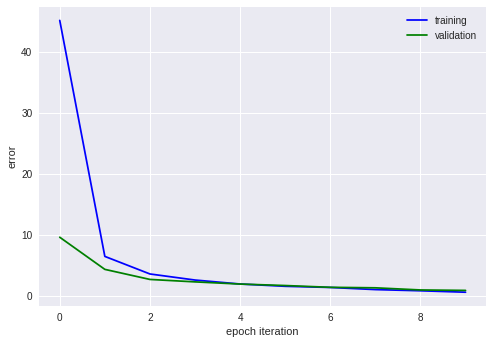

In [0]:
torch.manual_seed(0)
HYPER_PARAMS_VGG = OrderedDict(
    
    conv1 = dict(
        input_size = 1,
        output_size = 64,
        kernel_size = (3,3),
        padding_size = 0,
        stride_size = 1,
        dilation_size = 1,
    ),
     
    relu1 = dict(),
    
    conv2 = dict(
        input_size = 64,
        output_size = 128,
        kernel_size = (3,3),
        padding_size = 0,
        stride_size = 1,
        dilation_size = 1,
    ),
     
    relu2 = dict(),
    
    pool1 = dict(
        kernel_size = (2,2),
        stride_size= 2,
    ),
    
    conv3 = dict(
        input_size = 128,
        output_size = 256,
        kernel_size = (3,3),
        padding_size = 2,
        stride_size = 2,
        dilation_size = 1,
    ),
    
    relu3 = dict(),
    
    conv4 = dict(
        input_size = 256,
        output_size = 256,
        kernel_size = (3,3),
        padding_size = 2,
        stride_size = 2,
        dilation_size = 1,
    ),
    
    relu4 = dict(),
    
    pool2 = dict(
        kernel_size = (2,2),
        stride_size = 2,
    ),
    
    pool3 = dict(
        kernel_size = (2,2),
        stride_size = 2,
    ),
    
    fc1 = dict(
        input_size=256,
        output_size=64,
    ),
    
    relu5 = dict(),
    
    fc2 = dict(
        input_size=64,
        output_size=10
    ),
    
 
)

if __name__ == '__main__':
    
    clf = CNN(**HYPER_PARAMS_VGG, learning_rate=0.05)
    if torch.cuda.is_available():
        logging.info('Running on GPU')
        clf = clf.cuda()
    
    print("Number of parameters: ", sum(p.numel() for p in clf.parameters() if p.requires_grad))
    
    train_error,valid_error = clf.train_model(train, valid)
    print(train_error)
    print(valid_error)
    print("This is the training error, validation error vs epochs")
    
    epoch_range = list(range(DEFAULT_NUM_EPOCHS))
    plt.figure(1)
    plt.plot(epoch_range, train_error, '-', color='b')
    plt.plot(epoch_range, valid_error, '-', color='g')
    plt.ylabel("error")
    plt.xlabel("epoch iteration")
    plt.legend(labels = ["training", "validation"])
    plt.show()

The validation accuracy of 99.067. As we can see this improved the validation accuracy. 

In [0]:
torch.manual_seed(0)
clf.load('{}_{}'.format(DEFAULT_MODEL_PATH, 9))
clf.eval()
accuracy = clf.test(test)
print(accuracy)

98.26


##Final model

The final test set accuracy is : 98.26. We can see that it is close to the validation accuracy.

Our final model architecture has 4 convolutions and 3 max pooling. We do two convolutions followed by a max pooling. Each convolution uses squared kernel of size 3 with stride of 1 and no padding.
First convolution expands the feature space from 1 to 64.
The second convolution expands from 64 to 128 features.
Then we do a max pooling with no overlapping with a squared kernel of 2 and stride of 2.
The third convolution expends the feature space from 128 to 256.
the fourth convolution expends the feature space from 256 to 256.
We do two max poolings in a row again with squared kernel of size 2 and stride 2.
Finally we have two fully connected layers.
First going from 256 to 100 and second one from 100 to actual output size of 10.

The final conv. net has a total of 976842 parameters.

From the following tests we can see that with a very small system with 348374 parameters, which is less than 50% of the number of parameters of the MLP, we were able to get 94% accuracy without any hyperparameter tweaking compared to the MLP which had 94% accuracy with much more parameters to learn. We were able to increase the accuracy by increasing the number of parameters of the convolutional neural network to be close the the number of parameters in the MLP. This increased the accuracy significantly to 99%. Further hyperparameter changes could be done in order to make the convolutional network better but as we can see with the convolutional neural network architecture we can get quite a good accuracy without using many parameters which increases the performance while training. Further optimization could be done to increase the accuracy of our model such as adding regularization techniques such as dropout. It is clear that convolutional neural networks work better as image classification models. 

# Problem 3

Our Kaggle submission is under the team name 3M00SKETEER$

**Architecture: **
The first architecture that we used to test the Kaggle dataset was based on the VGG architecture. We utilised 8 convolutions, 4 max pooling and two fully connected layers. As with VGG are kernels were square of size three and max poolings of with squared kernels of size 2. 

We used the pattern 2 convolution followed by a max pooling with no overlapping. Each convolution is done with zero padding and strides of 1. We do two convolutions in a row of with the same output channels then followed by a max pooling. We used Relu as our activation function.

We started with 3 channels with dimension 3,64,64. We then do two convolutions with squared kernel of 3 with zero padding to expand to 64 features in both convolutions.Then we expend to 128 features with two other convolutions. Then we expend to 256 channels with two other convolutions. Finally two convolutions of feature size 512. The final output size is of 1. We then apply fully connected layer with 512x1x1 to 64. Then apply another relu to then apply another fully connected layer from 64 to final output size 2.


Here is a detailed feature output description of our architecture: \\
Conv1: \\
input size : 3,32,32 \\
kernel = 7x7 \\
output size: 64, 32, 32
 \\
Conv2: \\
input size : 64,62,62 \\
kernel = 3x3 \\
output = $[\frac{62 - 3}{1}]+1$ = 60 \\
 \\
Max pooling:\\
input size : 64,60,60 \\
kernel = 2x2 \\
output = $[\frac{60 - 2}{2}]+1$ = 30 \\
 \\
Conv3: \\
input size : 64,30,30 \\
kernel = 3x3 \\
output = $[\frac{30 - 3}{1}]+1$ = 28 \\
 \\
Conv4: 
input size : 128,28,28 \\
kernel = 3x3 \\
output = $[\frac{28 - 3}{1}]+1$ = 26 \\
 \\
Max pooling:\\
input size : 128,26,26 \\
kernel = 2x2 \\
output = $[\frac{26 - 2}{2}]+1$ = 13 \\
 \\
Conv5: \\
input size :128,13,13 \\
kernel = 3x3 \\
output = $[\frac{13 - 3}{1}]+1$ = 11 \\
 \\
Conv6: 
input size : 256,11,11 \\
kernel = 3x3 \\
output = $[\frac{11 - 3}{1}]+1$ = 9 \\
 \\
Max pooling:\\
input size : 256,9,9 \\
kernel = 2x2 \\
output = $[\frac{9 - 2}{2}]+1$ = 4 \\
 \\
Conv7: \\
input size :256,4,4 \\
kernel = 3x3 \\
output = $[\frac{4 - 3}{1}]+1$ = 2 \\
 \\
Conv8: 
input size : 512,20,20 \\
kernel = 2x2 \\
output = $[\frac{2 - 2}{1}]+1$ = 1 \\
 \\
Max pooling:\\
input size : 512,1,1 \\
kernel = 2x2 \\
output = $[\frac{1 - 2}{2}]+1$ = 1 \\
 \\
Fully connected 1: \\
input 512x1x1 output:64
 \\
Fully Connected 1: \\
 \\
The total number of parameters for our cnn is 3407618 \\



In [0]:
import torch
from torch.autograd import Variable
import torch.optim as optim
import torch.nn.functional as F
import numpy as np

DEFAULT_MODEL_PATH = 'content/drive/My Drive/IFT 6135/IFT6135assignment1/Kaggle/models/'

class CNN(torch.nn.Module):
  
    def __init__(self, model_path=DEFAULT_MODEL_PATH, *args, **kwargs):
      
        # Call to super-constructor
        super(CNN, self).__init__()
        #conv1_out_size = self.compute_layer_size(self.input_size, self.kernel_size_1,  self.padding_size_1, self.stride_size_1, self.dilation_size_1)
        self.path = model_path     
        # Sets up our layers
        self.conv1 = torch.nn.Conv2d(3, 64, 3)
        torch.nn.init.xavier_uniform_(self.conv1.weight)
        self.conv2 = torch.nn.Conv2d(64, 64, 3)
        torch.nn.init.xavier_uniform_(self.conv2.weight)
        self.pool1 = torch.nn.MaxPool2d(kernel_size=2, stride=2, padding=0)
        
        self.conv3 = torch.nn.Conv2d(64, 128, 3)
        torch.nn.init.xavier_uniform_(self.conv3.weight)
        self.conv4 = torch.nn.Conv2d(128, 128, 3)
        torch.nn.init.xavier_uniform_(self.conv4.weight)
        self.pool2 = torch.nn.MaxPool2d(kernel_size=2, stride=2, padding=0)

        self.conv5 = torch.nn.Conv2d(128, 256, 3)
        torch.nn.init.xavier_uniform_(self.conv5.weight)
        self.conv6 = torch.nn.Conv2d(256, 256, 3)
        torch.nn.init.xavier_uniform_(self.conv6.weight)
        self.pool3 = torch.nn.MaxPool2d(kernel_size=2, stride=2, padding=0)

        self.conv7 = torch.nn.Conv2d(256, 512, 3)
        torch.nn.init.xavier_uniform_(self.conv7.weight)
        self.conv8 = torch.nn.Conv2d(512, 512, 2)
        torch.nn.init.xavier_uniform_(self.conv8.weight)
        self.pool4 = torch.nn.MaxPool2d(kernel_size=2, stride=2, padding=0)
        
        self.fc1 = torch.nn.Linear(512, 64)

        self.fc2 = torch.nn.Linear(64, 2)

    def forward(self, x):
        
        # First convolutional layer
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = self.pool1(x)
        
        x = F.relu(self.conv3(x))
        x = F.relu(self.conv4(x))
        x = self.pool2(x)

        x = F.relu(self.conv5(x))
        x = F.relu(self.conv6(x))
        x = self.pool3(x)

        x = F.relu(self.conv7(x))
        x = F.relu(self.conv8(x))
        x = self.pool4(x)

        # First fully connected layer
        x = x.view(-1, 512)
        x = self.fc1(x)
        x = F.relu(x)
        
        # Second fully connected module
        x = self.fc2(x)
        return x

    def save(self, path=None):
        """Saves the model to the desired path."""
        if path is None:
            path = self.path
            
        torch.save(self.state_dict(), path)

    def load(self, path=None):
        """Loads the model from desired path."""
        if path is None:
            path = self.path
            
        self.load_state_dict(torch.load(path))

    def train_model(self, train_loader, valid_loader,
                  num_epochs=10, save_mode='every',
                    smart_detection=True,  silent=False):

        optimizer = optim.SGD(self.parameters(), lr=0.01, momentum=0.0)
        criterion = torch.nn.CrossEntropyLoss()
        validation_loss_per_epoch = []
        training_loss_per_epoch = []
        training_error_per_epoch = []
        valid_error_per_epoch = []
        validation_accuracy = 0
        
        for epoch in range(num_epochs):
            print("Starting epoch ", epoch)
            training_loss = []
            correct_trainning = 0
            total = 0
            correct = 0
            lmbd = 0.9 
            for i, data in enumerate(train_loader, 0):
                inputs,target = data
                if torch.cuda.is_available():
                    inputs = inputs.cuda()
                    target = target.cuda()
                optimizer.zero_grad()
                input_var = torch.autograd.Variable(inputs)
                target_var = torch.autograd.Variable(target)
                output = self(input_var)
                loss = criterion(output, target_var)
                reg = 1e-6
                l2_loss = None
                for name, param in self.named_parameters():
                    if 'bias' not in name: 
                        if l2_loss is None:
                            l2_loss = 0.5 * reg *torch.sum(torch.pow(param, 2))
                        else:
                            l2_loss += (0.5 * reg *torch.sum(torch.pow(param, 2)))

                loss += l2_loss
                training_loss.append(loss.item())
                loss.backward()
                optimizer.step()
                _, predicted = torch.max(output.data, 1)
                total += target_var.size(0)
                correct += (predicted == target_var).sum().item()
                if i%50==0 and not silent:
                    print('Epoch : %d accuracy : %.3f ' % (epoch, 100*(correct/total)))

            training_loss_per_epoch.append(np.mean(training_loss))
            training_error_per_epoch.append(1 - (correct/total))
            validation_loss = [];
            val_size = len(list(valid_loader))
            val_correct = 0 
            val_total = 0
            for i, data in enumerate(valid_loader, 0):
                inputs,target = data
                if torch.cuda.is_available():
                    inputs = inputs.cuda()
                    target = target.cuda()
                input_var = torch.autograd.Variable(inputs)
                target_var = torch.autograd.Variable(target)
                output = self.forward(input_var)
                loss = criterion(output, target_var)
                validation_loss.append(loss.item())
                _, predicted = torch.max(output.data, 1)
                val_total += target_var.size(0)
                val_correct += (predicted == target_var).sum().item()
                if i%50==0 and not silent:
                    print('Epoch : %d validation accuracy: %.3f ' % (epoch, 100*(val_correct/val_total)))
            validation_loss_per_epoch.append(np.mean(validation_loss))
            validation_accuracy = val_correct/val_total
            valid_error_per_epoch.append(1 - (val_correct/val_total))
            print('Epoch : %d validation Acc : %.3f' % (epoch, 100.*val_correct/val_total))
            print('--------------------------------------------------------------')
            print("done epoch ", epoch)

            if save_mode == 'every' or epoch % save_mode == 0:
                self.save('{}_{}.{}'.format(self.path, epoch,'pth'))

        return training_loss_per_epoch,validation_loss_per_epoch,training_error_per_epoch,valid_error_per_epoch,validation_accuracy

    def compute_layer_size(self, input_size, kernel_size, padding = 0, stride = 1, dilation = 1):
    
        ks = (kernel_size) + (dilation - 1) * (kernel_size - 1)
        
        return np.floor((input_size - ks - (2 * padding)) / (stride)) - 1

##Hyperparameter search

Using this first architecture we first ran the model with 50 epoch and here are the following graph of error vs epoch iteration. 

For all graphs the blue squares represents the validation set and the green triangles represent the training set. 

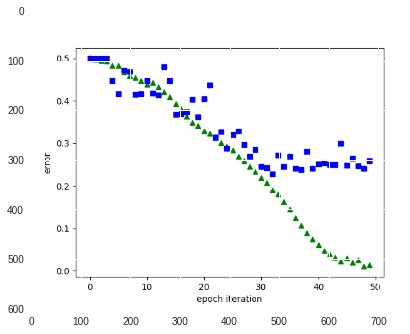

In [0]:
import matplotlib.image as mpimg
img=mpimg.imread('/content/drive/My Drive/IFT 6135/IFT6135assignment1/Kaggle cnn results (1)/images/image2.png')

imgplot = plt.imshow(img)

As we can see from the following graph the validation error plateaus around 35 epochs which suggests  that we there is no point in training more than 35 epoch as it might overfit the data. 

##Reduced number epochs
We now reduced the number of epochs to 35. Here is the graph of loss vs epochs. 

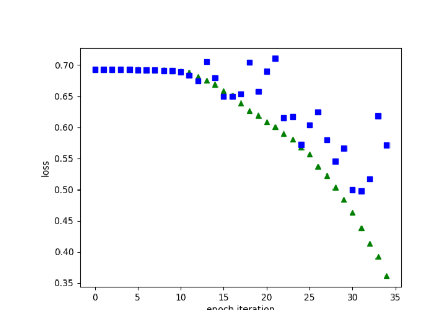

In [0]:
import matplotlib.image as mpimg
img=mpimg.imread('/content/drive/My Drive/IFT 6135/IFT6135assignment1/Kaggle cnn results (1)/images/image3.png')
plt.axis('off')
imgplot = plt.imshow(img)

Here is the graph Error vs epoch iteration. 

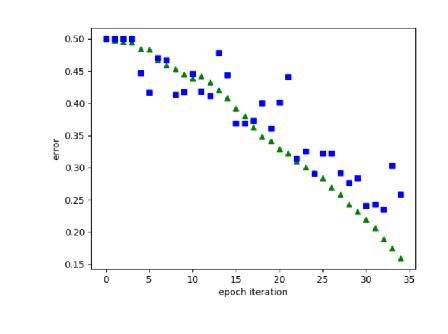

In [0]:
import matplotlib.image as mpimg
img=mpimg.imread('/content/drive/My Drive/IFT 6135/IFT6135assignment1/Kaggle cnn results (1)/images/35_epoch.PNG')
plt.axis('off')
imgplot = plt.imshow(img)

We can see from this graph that the optimal epoch number would be a maximum of 30 as the validation  starts to increase after 
30 epochs. 

##Add transformations to dataset
We then added transformation to the dataset. Normalization, scaling, random affine and horizontal flipping. We also put the epoch high to evaluate where it starts to overfit for the new transformed dataset. We also normalize the validation set to make sure the input data matches. 
Here is the loss vs epoch iteration.

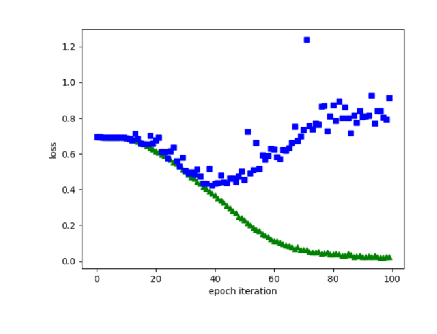

In [0]:
import matplotlib.image as mpimg
img=mpimg.imread('/content/drive/My Drive/IFT 6135/IFT6135assignment1/Kaggle cnn results (1)/images/100_epoch.PNG')
plt.axis('off')
imgplot = plt.imshow(img)

Error vs epoch iteration

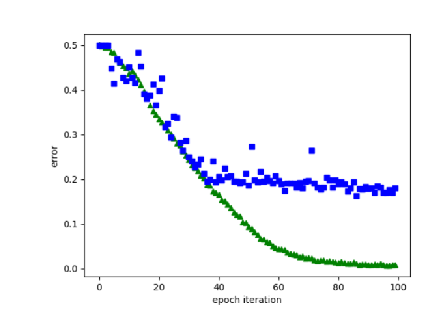

In [0]:
import matplotlib.image as mpimg
img=mpimg.imread('/content/drive/My Drive/IFT 6135/IFT6135assignment1/Kaggle cnn results (1)/images/100_epoch_error.PNG')
plt.axis('off')
imgplot = plt.imshow(img)

We can see from this graph that the validation loss is increasing around epoch 40. We should use a value below 40 epochs to avoid overfitting our model. 

##L2 regularization
We added L2 regularization to our model with 50 epoch training phase. Here is the loss vs epoch iteration graph. 

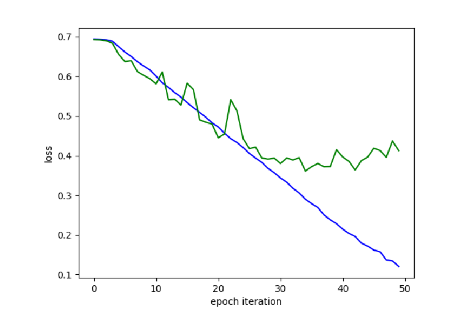

In [0]:
import matplotlib.image as mpimg
img=mpimg.imread('/content/drive/My Drive/IFT 6135/IFT6135assignment1/Kaggle cnn results (1)/images/epoch_50_final.PNG')
plt.axis('off')
imgplot = plt.imshow(img)

Error vs epoch iteration

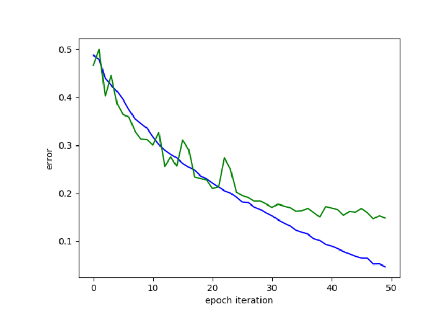

In [0]:
import matplotlib.image as mpimg
img=mpimg.imread('/content/drive/My Drive/IFT 6135/IFT6135assignment1/Kaggle cnn results (1)/images/epoch_50_final_error.PNG')
plt.axis('off')
imgplot = plt.imshow(img)

From the above graphs we can see that the loss start to go back up a little around epoch 45. The error seems to be continuing to decrease at epoch 50. We then decided to train for more epoch to check what the loss graph would look like. We also tested the accuracy of our model at epoch 40 with the test set and got 84.7%. The validation accuracy with the same model is 83.4 which we can see if very similar to the test accuracy. 

Here is the graph for 100 epochs.

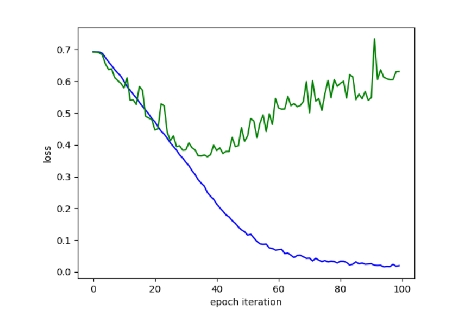

In [0]:
import matplotlib.image as mpimg
img=mpimg.imread('/content/drive/My Drive/IFT 6135/IFT6135assignment1/Kaggle cnn results (1)/images/epoch_100_loss.PNG')
plt.axis('off')
imgplot = plt.imshow(img)

Error vs epoch iteration graph

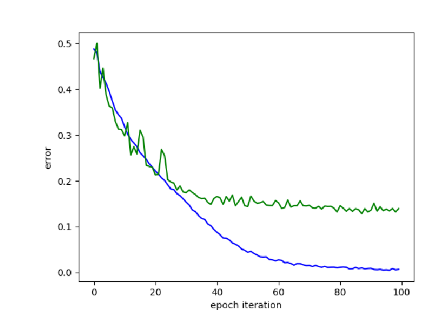

In [0]:
import matplotlib.image as mpimg
img=mpimg.imread('/content/drive/My Drive/IFT 6135/IFT6135assignment1/Kaggle cnn results (1)/images/epoch_100_error.PNG')
plt.axis('off')
imgplot = plt.imshow(img)

As we can see from the loss vs epoch iteration graph at 100 epochs the loss starts to increase between epoch 40 -50. From the error graph the final error of the validation plateaus around the same epochs. Testing a later model at epoch 60 on the test set gave us and accuracy of 85.6%. It is an improvement but there is a good chance that we overfit the model and that testing on other test sets might not work as well. We believe that the model at epoch 40 will be able to better generalize on more test sets. For this model the validation accuracy was 84.8% which is similar to the test accuracy. 

The model recorded at epoch 40 with L2 regularization was used as one of our 2 final submissions. 

## Resnet Architecture
We likewise experimented with a Resnet style architecture. Our resnet was inspired from the Resnet 18 architecture in the orginal Resnet paper. The main difference is that our implementation didn't include batch norm. The Resnet model was the final model chosen for our Kaggle evaluation.

The main feature of the Resnet architecture is the skip connection that allows for greater gradient propagation and thus the ability to properly train deeper networks. The Resnet18 model contains 8 residual blocks, each one containing 2 convolutional layers and 2 skip connections. 

The skip connections worked in two ways: when the dimension was identical, they simply applied identity mapping. When the dimmensionality changed, they performed identity mapping with 1x1 convolution in-order to increase the dimension.

References: \\
https://arxiv.org/abs/1512.03385 \\
https://towardsdatascience.com/an-overview-of-resnet-and-its-variants-5281e2f56035 \\

Here is a detailed feature output description of our Resnet architecture: \\

Conv1: \\
input size : 3,64,64 \\
kernel = 7x7 \\
stride = 2 \\
padding = 3 \\
output size = 64, 32, 32 \\

Max pooling: \\
input size : 64,32,32 \\
kernel = 3x3 \\
output = 64, 16, 16 \\

__Residual Block 1__
 \\
Conv1: \\
input size : 64,16,16 \\
kernel = 3x3 \\
padding=1 \\
stride=1 \\
output size= 64, 16, 16 \\
 \\
Conv2: \\
input size : 64, 16, 16 \\
kernel = 3x3 \\
padding=1 \\
stride=1 \\
output size=  64, 16, 16 \\
 \\
__Residual Block 2__
 \\
Conv1: \\
input size : 64, 16, 16 \\
kernel = 3x3 \\
padding=1 \\
stride=1 \\
output size=  64, 16, 16 \\
 \\
 Conv2: \\
input size : 64, 16, 16 \\
kernel = 3x3 \\
padding=1 \\
stride=1 \\
output size=  64, 16, 16 \\
 \\
 __Residual Block 3__
 \\
Conv1: \\
input size : 64, 16, 16 \\
kernel = 3x3 \\
padding=1 \\
stride=2
output size=  128, 8, 8 \\
 \\
 Conv2: \\
input size : 128, 8, 8  \\
kernel = 3x3 \\
padding=1 \\
stride=1 \\
output size=  128, 8, 8  \\
 \\
 __Residual Block 4__
 \\
 Conv1: \\
input size : 128, 8, 8  \\
kernel = 3x3 \\
padding=1 \\
stride=1 \\
output size=  128, 8, 8  \\
 \\
 Conv2: \\
input size : 128, 8, 8  \\
kernel = 3x3 \\
padding=1 \\
output size=  128, 8, 8  \\
 \\
 __Residual Block 5__
 \\
 Conv1: \\
input size : 128, 8, 8  \\
kernel = 3x3 \\
padding=1 \\
stride=2 \\
output size=  256, 4, 4  \\
 \\
 Conv2: \\
input size : 256, 4, 4  \\
kernel = 3x3 \\
padding=1 \\
stride=1 \\
output size=  256, 4, 4  \\
 \\
  __Residual Block 6__
 \\
 Conv1: \\
input size : 256, 4, 4  \\
kernel = 3x3 \\
padding=1 \\
stride=1 \\
output size=  256, 4, 4  \\
 \\
 Conv2: \\
input size : 256, 4, 4  \\
kernel = 3x3 \\
padding=1 \\
stride=1 \\
output size=  256, 4, 4  \\
 \\
  __Residual Block 7__
 \\
Conv1: \\
input size : 256,4,4 \\
kernel = 3x3 \\
padding=1 \\
stride=2 \\
output = 512, 2, 2 \\
 \\
Conv2: \\
input size : 512,2,2 \\
kernel = 3x3 \\
padding=1 \\
stride=1 \\
output = 512, 2, 2 \\
 \\
  __Residual Block 8__
 \\
Conv1: \\
input size : 512,2,2 \\
kernel = 3x3 \\
padding=1 \\
stride=1 \\
output = 512, 2, 2 \\
 \\
Conv2: \\
input size : 512,2,2 \\
kernel = 3x3 \\
padding=1 \\
stride=1 \\
output = 512, 2, 2 \\
 \\
 
Average Pool: \\
input size : 512,2,2 \\
kernel = 1x1 \\
padding=1 \\
output = 512, 1, 1 \\

Fully connected 1: \\
input: 512x1x1 \\
output:2 \\
 \\

The total number of parameters for our resnet is 11172738 \\
This model was used as our final architecture for kernel visualization and misclassification.

In [0]:
import torch
from torch.autograd import Variable
import torch.optim as optim
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt

DEFAULT_MODEL_PATH = './'

class ResNet(torch.nn.Module):
  
    def __init__(self, model_path=DEFAULT_MODEL_PATH, *args, **kwargs):
      
        # Call to super-constructor
        super(ResNet, self).__init__()
        self.path = model_path
        # Sets up our layers
        self.conv1 = torch.nn.Conv2d(3, 64, 7, stride=2, padding=3)
        torch.nn.init.xavier_uniform_(self.conv1.weight)
        self.pool1 = torch.nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        
        self.conv2_1 = torch.nn.Conv2d(64, 64, 3, padding=1)
        self.conv2_2 = torch.nn.Conv2d(64, 64, 3, padding=1)
        self.conv2_3 = torch.nn.Conv2d(64, 64, 3, padding=1)
        self.conv2_4 = torch.nn.Conv2d(64, 64, 3, padding=1)
                
        torch.nn.init.xavier_uniform_(self.conv2_1.weight)
        torch.nn.init.xavier_uniform_(self.conv2_2.weight)
        torch.nn.init.xavier_uniform_(self.conv2_3.weight)
        torch.nn.init.xavier_uniform_(self.conv2_4.weight)
        
        self.conv3_b = torch.nn.Conv2d(64, 128, 1, stride=2)
        self.conv3_1 = torch.nn.Conv2d(64, 128, 3, stride=2, padding=1)
        self.conv3_2 = torch.nn.Conv2d(128, 128, 3, padding=1)
        self.conv3_3 = torch.nn.Conv2d(128, 128, 3, padding=1)
        self.conv3_4 = torch.nn.Conv2d(128, 128, 3, padding=1)
        torch.nn.init.xavier_uniform_(self.conv3_b.weight)
        torch.nn.init.xavier_uniform_(self.conv3_1.weight)
        torch.nn.init.xavier_uniform_(self.conv3_2.weight)
        torch.nn.init.xavier_uniform_(self.conv3_3.weight)
        torch.nn.init.xavier_uniform_(self.conv3_4.weight)

        self.conv4_b = torch.nn.Conv2d(128, 256, 1, stride=2)
        self.conv4_1 = torch.nn.Conv2d(128, 256, 3, stride=2, padding=1)
        self.conv4_2 = torch.nn.Conv2d(256, 256, 3, padding=1)
        self.conv4_3 = torch.nn.Conv2d(256, 256, 3, padding=1)
        self.conv4_4 = torch.nn.Conv2d(256, 256, 3, padding=1)
        torch.nn.init.xavier_uniform_(self.conv4_b.weight)
        torch.nn.init.xavier_uniform_(self.conv4_1.weight)
        torch.nn.init.xavier_uniform_(self.conv4_2.weight)
        torch.nn.init.xavier_uniform_(self.conv4_3.weight)
        torch.nn.init.xavier_uniform_(self.conv4_4.weight)        

        self.conv5_b = torch.nn.Conv2d(256, 512, 1, stride=2)
        self.conv5_1 = torch.nn.Conv2d(256, 512, 3, stride=2, padding=1)
        self.conv5_2 = torch.nn.Conv2d(512, 512, 3, padding=1)
        self.conv5_3 = torch.nn.Conv2d(512, 512, 3, padding=1)
        self.conv5_4 = torch.nn.Conv2d(512, 512, 3, padding=1)
        torch.nn.init.xavier_uniform_(self.conv5_b.weight)
        torch.nn.init.xavier_uniform_(self.conv5_1.weight)
        torch.nn.init.xavier_uniform_(self.conv5_2.weight)
        torch.nn.init.xavier_uniform_(self.conv5_3.weight)
        torch.nn.init.xavier_uniform_(self.conv5_4.weight)
        
        self.pool_avg = torch.nn.AdaptiveAvgPool2d((1, 1))

        self.fc1 = torch.nn.Linear(512, 2)

    def forward(self, x):
        # First convolutional layer
        x = self.conv1(x)
        x = F.relu(x)
        x = self.pool1(x)
        
        # Conv layer2
        x_bypass = x
        x = self.conv2_1(x)
        x = F.relu(x)
        x = self.conv2_2(x) + x_bypass
        x = F.relu(x)
        x = self.conv2_3(x)
        x = F.relu(x)
        x = self.conv2_4(x) + x_bypass
        x = F.relu(x)
        
        # Conv layer3
        
        x_bypass = self.conv3_b(x)
        x = self.conv3_1(x)
        x = F.relu(x)
        x = self.conv3_2(x) + x_bypass
        x = F.relu(x)
        
        x_bypass = x
        x = self.conv3_3(x)
        x = F.relu(x)
        x = self.conv3_4(x) + x_bypass
        x = F.relu(x)
        
        # Conv layer4
        x_bypass = self.conv4_b(x)
        x = self.conv4_1(x)
        x = F.relu(x)
        x = self.conv4_2(x) + x_bypass
        x = F.relu(x)
        
        x_bypass = x
        x = self.conv4_3(x)
        x = F.relu(x)
        x = self.conv4_4(x) + x_bypass
        x = F.relu(x)
        
        #Conv layer5
        
        x_bypass = self.conv5_b(x)
        x = self.conv5_1(x)
        x = F.relu(x)
        x = self.conv5_2(x) + x_bypass
        x = F.relu(x)
        
        x_bypass = x
        x = self.conv5_3(x)
        x = F.relu(x)
        x = self.conv5_4(x) + x_bypass
        x = F.relu(x)
        
        # Average pool
        x = self.pool_avg(x)
        x = x.squeeze()
        x = self.fc1(x)
        x = F.softmax(x)

        return x

    def save(self, path=None):
        """Saves the model to the desired path."""
        if path is None:
            path = self.path
            
        torch.save(self.state_dict(), path)

    def load(self, path=None):
        """Loads the model from desired path."""
        if path is None:
            path = self.path
            
        self.load_state_dict(torch.load(path))

    def train_model(self, train_loader, valid_loader,
                  num_epochs=10, save_mode='every',
                    smart_detection=True, silent=False):

        optimizer = optim.SGD(self.parameters(), lr=0.1, momentum=0.0)
        
        # Sets up variable learning rate
        lambda1 = lambda epoch: epoch // 30
        lambda2 = lambda epoch: 0.95 ** epoch
        #scheduler = optim.lr_scheduler.LambdaLR(optimizer, lr_lambda=[lambda1, lambda2])
        scheduler = optim.lr_scheduler.LambdaLR(optimizer, lr_lambda=[lambda2])
        
        criterion = torch.nn.CrossEntropyLoss()
        validation_loss_per_epoch = []
        training_loss_per_epoch = []
        training_error_per_epoch = []
        valid_error_per_epoch = []
        validation_accuracy = 0
        print('Training...')
        for epoch in range(num_epochs):
            training_loss = []
            correct_trainning = 0
            total = 0
            correct = 0
            lmbd = 0.9 
            self.train()
            for i, data in enumerate(train_loader):
                inputs, target = data
                
                #print('Target mean: {}'.format(target.numpy().astype(np.float32).mean()))
                if torch.cuda.is_available():
                    inputs = inputs.cuda()
                    target = target.cuda()
                optimizer.zero_grad()
                input_var = torch.autograd.Variable(inputs)
                target_var = torch.autograd.Variable(target)
                output = self(input_var)
                #print(output.shape)
                loss = criterion(output, target_var)
                reg = 1e-6
                l2_loss = None
                for name, param in self.named_parameters():
                    if 'bias' not in name: 
                        if l2_loss is None:
                            l2_loss = 0.5 * reg *torch.sum(torch.pow(param, 2))
                        else:
                            l2_loss += (0.5 * reg *torch.sum(torch.pow(param, 2)))

                loss += l2_loss
                training_loss.append(loss.item())
                loss.backward()
                optimizer.step()
                _, predicted = torch.max(output.data, 1)
                total += target_var.size(0)
                correct += (predicted == target_var).sum().item()
                if i % 50 == 0:
                    print("Done batch {}. Loss: {}. Correct: {}".format(i, loss.item(), (predicted == target_var).sum().item()))
            training_loss_per_epoch.append(np.mean(training_loss))
            training_error_per_epoch.append(1 - (correct/total))
            print(correct/total)
            validation_loss = [];
            val_size = len(list(valid_loader))
            val_correct = 0 
            val_total = 0
            self.eval()
            

            for i, data in enumerate(valid_loader, 0):
                inputs,target = data
                #print('Target mean: {}'.format(target.numpy().astype(np.float32).mean()))
                if torch.cuda.is_available():
                    inputs = inputs.cuda()
                    target = target.cuda()
                input_var = torch.autograd.Variable(inputs)
                target_var = torch.autograd.Variable(target)
                output = self(input_var)
                loss = criterion(output, target_var)
                validation_loss.append(loss.item())
                _, predicted = torch.max(output.data, 1)
                
                # Checks for 50/50
                if epoch > 5:
                    d = output.data.cpu().numpy()
                    
                    for b in range(len(d)):
                        if d[b][0] > 0.49 and d[b][0] < 0.51 and d[b][1] > 0.49 and d[b][1] < 0.51:
                            #print(inputs[b].shape)
                            img = inputs[b].cpu().numpy().swapaxes(0,2)
                            plt.imshow(img)
                            plt.show()
                
                val_total += target_var.size(0)
                val_correct += (predicted == target_var).sum().item()
                if i % 50 == 0:
                    print("Done batch validation {}, Loss: {}, Correct: {}".format(i, loss.item(), (predicted == target_var).sum().item()))
            validation_loss_per_epoch.append(np.mean(validation_loss))
            validation_accuracy = val_correct/val_total
            print(validation_accuracy)
            valid_error_per_epoch.append(1 - (val_correct/val_total))
            print("done epoch ", epoch)

            if save_mode == 'every' or epoch % save_mode == 0:
                self.save('{}_{}.{}'.format(self.path, epoch,'pth'))

        return training_loss_per_epoch,validation_loss_per_epoch,training_error_per_epoch,valid_error_per_epoch,validation_accuracy

    def compute_layer_size(self, input_size, kernel_size, padding = 0, stride = 1, dilation = 1):
    
        ks = (kernel_size) + (dilation - 1) * (kernel_size - 1)
        
        return np.floor((input_size - ks - (2 * padding)) / (stride)) - 1

In [0]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
from torch.utils.data.sampler import SubsetRandomSampler, SequentialSampler
import matplotlib.pyplot as plt
import csv
import pandas as pd
from torch.autograd import Variable
from torchvision.transforms import ToPILImage
from IPython.display import Image
to_img = ToPILImage()


seed = 42
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
torch.backends.cudnn.deterministic=True

train_dir = "./trainset"
test_dir = "./testset"
valid_dir = "./validset"

train_trans = transforms.Compose([
        transforms.RandomHorizontalFlip(0.5),
        transforms.ColorJitter(
            brightness=0.4,
            contrast=0.4,
            saturation=0.4,
            hue=0.4,
        ),
        transforms.RandomAffine(
            degrees=(-90,90),
            translate=(1.0, 1.0),
            scale=(0.1, 2.0),
            shear=(-90,90),
        ),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])


# Validation transformations (No need to randomly make validation harder)
valid_trans =  transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

train_trans =  transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

train_datasets = datasets.ImageFolder(train_dir, train_trans)
valid_datasets = datasets.ImageFolder(valid_dir, valid_trans)

class_names = train_datasets.classes

train_dataloaders = torch.utils.data.DataLoader(train_datasets, batch_size=32, num_workers=1, shuffle=True, pin_memory=True)

validation_dataloaders = torch.utils.data.DataLoader(valid_datasets, batch_size=32, num_workers=1, shuffle=True, pin_memory=True)

test_datasets = datasets.ImageFolder(test_dir, train_trans)
dataset_size = len(test_datasets)
indices = list(range(dataset_size))
test_sampler = SequentialSampler(indices)

test_dataloaders = torch.utils.data.DataLoader(test_datasets, shuffle=False, num_workers=1, batch_size=32, pin_memory=False, sampler=test_sampler)

    
def main():
    n_epochs = 50
    cnn = ResNet()

    if torch.cuda.is_available():
        cnn = cnn.cuda()
    training_loss_per_epoch,validation_loss_per_epoch,training_error_per_epoch,valid_error_per_epoch,validation_accuracy = cnn.train_model(train_dataloaders, validation_dataloaders,num_epochs = n_epochs)
    print("Final validation accuracy: ", validation_accuracy)
    
    epoch_range = list(range(n_epochs))
    plt.figure(1)
    plt.plot(epoch_range, training_loss_per_epoch, 'g^', epoch_range, validation_loss_per_epoch, 'bs')
    plt.ylabel("loss")
    plt.xlabel("epoch iteration")
    plt.show()

    plt.figure(2)
    plt.plot(epoch_range, training_error_per_epoch, 'g^', epoch_range, valid_error_per_epoch, 'bs')
    plt.ylabel("error")
    plt.xlabel("epoch iteration")
    plt.show()

    final_predictions = np.empty([0,0])
    final_predictions2 = np.empty([0,0])
    cnn.eval()
    for i, data in enumerate(test_dataloaders):
        inputs,target = data
        inputs = inputs.cuda()
        target = target.cuda()
        input_var = torch.autograd.Variable(inputs)
        target_var = torch.autograd.Variable(target)
        output = cnn(input_var)
        _, predicted = torch.max(output.data, 1)
        final_predictions2 = np.append(final_predictions2, predicted.cpu().numpy())
    
    dictionary = {}
    i = 0
    for f in os.listdir('./testset/test/'):
        id = int(os.path.basename(os.path.splitext(f)[0]))
        dictionary[id] = final_predictions2[i]
        i+=1
    for key in sorted(dictionary.keys()):
        final_predictions = np.append(final_predictions, dictionary[key])

    df = pd.read_csv('./sample_submission.csv', delimiter= ',')
    map_classes = np.vectorize(lambda t: class_names[t])
    df['label'] = map_classes(final_predictions.astype(int).flatten())

    df.to_csv('./prediction.csv', index=False, sep=',')   

if __name__=='__main__':
    main()


### Results
Here is the graph of our training and validation losses after 30 epochs. As seen, the resnet architectures converges faster than the VGG styled one, but gains are minimal after 10 or so epochs. This was done using a learning rate of 0.1.

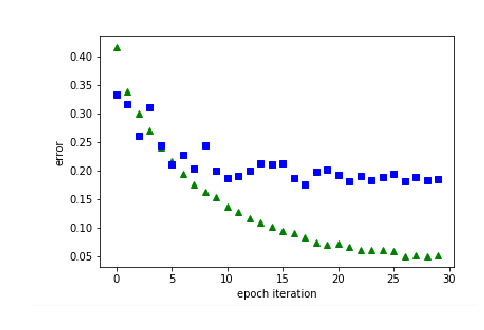

In [0]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
plt.axis('off')
img=mpimg.imread('/content/drive/My Drive/IFT 6135/IFT6135assignment1/Images/accuracy1.PNG')
imgplot = plt.imshow(img)

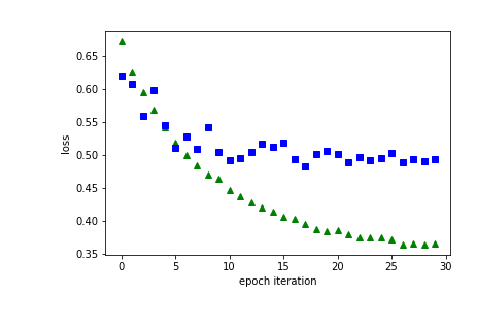

In [0]:
import matplotlib.image as mpimg
plt.axis('off')
img=mpimg.imread('/content/drive/My Drive/IFT 6135/IFT6135assignment1/Images/loss1.PNG')
imgplot = plt.imshow(img)

## Feature Map Visualization
Our feature map for our convolutional layers can be visualized in-order to get a perspective of what is output from our convolutional layers. As we can see, the feature map of the first convolutional layer visually looks like our animal image. As we go deeper into our network, the feature maps get more abstract.


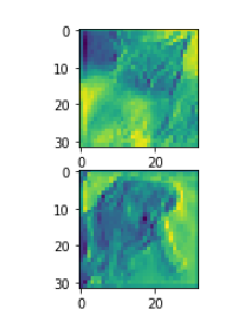

In [0]:
import matplotlib.image as mpimg
plt.axis('off')
img=mpimg.imread('/content/drive/My Drive/IFT 6135/IFT6135assignment1/Images/featuremap1.PNG')
imgplot = plt.imshow(img)

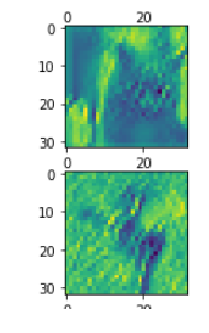

In [0]:
import matplotlib.image as mpimg
plt.axis('off')
img=mpimg.imread('/content/drive/My Drive/IFT 6135/IFT6135assignment1/Images/featuremap2.PNG')
imgplot = plt.imshow(img)

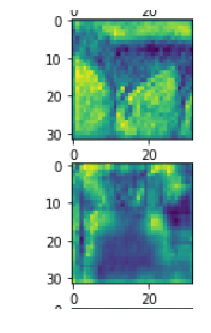

In [0]:
import matplotlib.image as mpimg
plt.axis('off')
img=mpimg.imread('/content/drive/My Drive/IFT 6135/IFT6135assignment1/Images/featuremap3.PNG')
imgplot = plt.imshow(img)

## Kernel Visualization

Kernels within our Resnet can be visualized in-order to reveal the effect they have on the output. Visualizing the first kernel shows us that, as expected, this layer is mainly responsible for detecting edge-like features in the image. As expected, the kernels deeper in the network track more complex features.


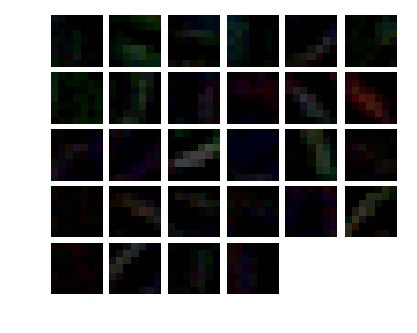

In [0]:
import matplotlib.image as mpimg
plt.axis('off')
img=mpimg.imread('/content/drive/My Drive/IFT 6135/IFT6135assignment1/Images/kernel.PNG')
imgplot = plt.imshow(img)

## 50/50 Images
For some images, the model had a prediction of around 50-50 Dog-Cat. Visually inspecting these, it appears that they fall into two categories. The first case is when we have dog breeds that appear very cat-like or cats that appear very dog-likes.


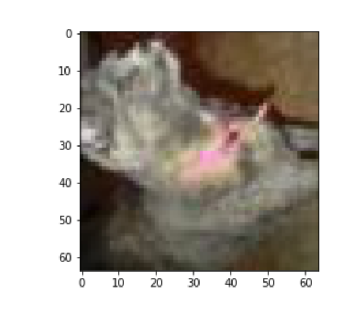

In [0]:
import matplotlib.image as mpimg
plt.axis('off')
img=mpimg.imread('/content/drive/My Drive/IFT 6135/IFT6135assignment1/Images/5050_1.png')
imgplot = plt.imshow(img)

The second case is image of things that are neither cats or dogs. For instance, some of the images in the test set appear to be simply the color white.

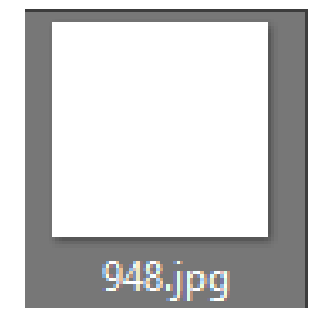

In [0]:
import matplotlib.image as mpimg
plt.axis('off')
img=mpimg.imread('/content/drive/My Drive/IFT 6135/IFT6135assignment1/Images/white.PNG')
imgplot = plt.imshow(img)

## Misclassified

Other images were simply misclassified even though the percentage was not near 50-50. In these cases, we hypothesize that our model didn't have enough examples similar to these in our training set, which made it perform worse on them.

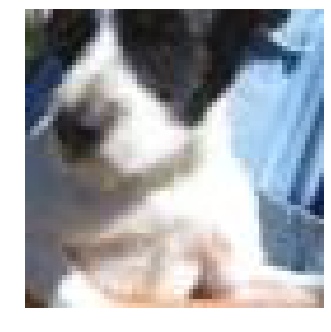

In [0]:
import matplotlib.image as mpimg
plt.axis('off')
img=mpimg.imread('/content/drive/My Drive/IFT 6135/IFT6135assignment1/Images/miss1.jpg')
imgplot = plt.imshow(img)

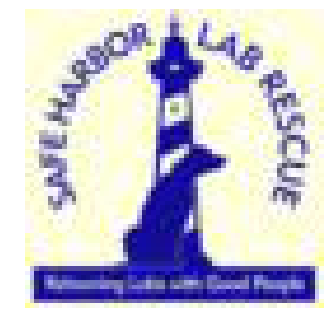

In [0]:
import matplotlib.image as mpimg
plt.axis('off')
img=mpimg.imread('/content/drive/My Drive/IFT 6135/IFT6135assignment1/Images/miss2.jpg')
imgplot = plt.imshow(img)

#Improvements

Below are a description of all the different approaches that could have been done to improve the final accuracy of our model for the kaggle submission. 

##Dropout
In order to improve our model generalize better on the test set we could have implemented dropout. The ideal situation would be to train on many different neural net architecture and combine them. This is not possible if trained separately as the parameters are not shared and would be very difficult to set up a final network model. Dropout allows you to do this by creating many different variations of your network by removing random nodes from the network. By doing this the network is exposed to many different network architectures all while keeping shared parameters that can be used in the final model. The test model does not use dropout but its weights are scaled down with the probability that was used on the unit during training with dropout. 

reference: [http://jmlr.org/papers/volume15/srivastava14a/srivastava14a.pdf](http://jmlr.org/papers/volume15/srivastava14a/srivastava14a.pdf)

##Batch normalization
We could also implement batch normalization which would help reduce the internal covariate shift that can occur on the hidden layers. By applying batch normalization this assure that the distribution of the inputs at each layer is approximately the same. By normalization the input at each layer this allows for the inputs to stay in approximately the same distribution reducing the differences from one batch to the next. This will improve training since each layer does not need to adapt to the constantly changing distribution of the input values. 

reference: [https://towardsdatascience.com/batch-normalization-theory-and-how-to-use-it-with-tensorflow-1892ca0173ad](https://towardsdatascience.com/batch-normalization-theory-and-how-to-use-it-with-tensorflow-1892ca0173ad)


##Early stopping
Implementing early stopping could help as well to find the best fitting model before it start to overfit. It would be more accurate than trying to figure out from the graphs at which epoch the model starts to overfit. By applying a patient variable in order to give a couple if iterations before it stops training we can assure that we are really stopping when the validation error or loss starts to constantly increase. 

##Data transformation 
Adding more data transformation could also improve the accuracy as it exposed the training to more variation of the training set which might help the model generalize better. 

##Deeper neural net
Creating a deeper neural net would also help increase the accuracy of our model. This would help the model to generalize more as it will learn richer features as we move up in the layers. 

###References
[VGG architecture](https://medium.com/@sidereal/cnns-architectures-lenet-alexnet-vgg-googlenet-resnet-and-more-666091488df5)

